# Homework 11 - Assignment 1

# Time series clustering exercise

### Compiled by Jonathan Kastelan aka #JKtours

#### Reference notebook from fbb

# Import packages

In [1]:

import pandas as pd
import zipfile 
import os
import geopandas as gpd
import pylab as pl
import time
from IPython.display import display, clear_output
from scipy.cluster.hierarchy import dendrogram, linkage
import sklearn.cluster
from scipy.cluster.vq import whiten
from scipy import cluster

from geopy.distance import great_circle
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster as scp


import choroplethNYC as cp

from scipy.spatial.distance import cdist, pdist

from sklearn.cluster import KMeans
from scipy.cluster.vq import kmeans2

from sklearn.cluster import DBSCAN

%pylab inline



Populating the interactive namespace from numpy and matplotlib


# Data

Download the census bureau business data for all years 1993-2014. 

#### I ran the code below provided by fbb to obtain the datasets. Please note the dataset for 1993 was requested but failed to pull from the website (we understand this dataset may not be available from this link)

In [ ]:
#these commands can be run on the shell and get the data with the command wget
#the cell needs to be run only once
!for ((y=93; y<=99; y+=1)); do wget \
ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp$y\totals.zip; done

!for ((y=0; y<=1; y+=1)); do wget \
ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp0$y\totals.zip; done

!for ((y=2; y<=9; y+=1)); do wget \
ftp://ftp.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done

!for ((y=10; y<=14; y+=1)); do wget \
ftp://ftp.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done



In [4]:
# Move data to folder in PUIDATA
os.system('mkdir ' + os.getenv('PUIDATA') + '/NYC_ZIPBusinessData')
for y in range(93,100,1):
    os.system('mv zbp' + str(y) + 'totals.zip ' + os.getenv('PUIDATA') + '/NYC_ZIPBusinessData')

for y in range(0,10,1):
    os.system('mv zbp0' + str(y) + 'totals.zip ' + os.getenv('PUIDATA') + '/NYC_ZIPBusinessData')
    
for y in range(10,15,1):
    os.system('mv zbp' + str(y) + 'totals.zip ' + os.getenv('PUIDATA') + '/NYC_ZIPBusinessData')

 Download the NYC zipcodes shapefile. One of many ways in which you can get the zipcodes shapefile for NYC
 https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip


In [5]:
# Download and unzip Zipcode shapefiles into PUIdata
!wget https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip -O NYCZipcodeShapes.zip
os.system('mkdir ' + os.getenv('PUIDATA') + '/NYC_Zipcode_Shapefile')
os.system("unzip " + 'NYCZipcodeShapes.zip' + " -d " + os.getenv('PUIDATA') + '/NYC_Zipcode_Shapefile')
os.system('mv NYCZipcodeShapes.zip ' + os.getenv('PUIDATA') + '/NYC_Zipcode_Shapefile' )

--2017-12-13 21:20:32--  https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip
Resolving data.cityofnewyork.us... 52.206.68.26
Connecting to data.cityofnewyork.us|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.cityofnewyork.us/api/views/i8iw-xf4u/files/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip [following]
--2017-12-13 21:20:32--  https://data.cityofnewyork.us/api/views/i8iw-xf4u/files/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip
Connecting to data.cityofnewyork.us|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1514401 (1.4M) [application/octet-stream]
Saving to: “NYCZipcodeShapes.zip”

100%[======================================>] 1,514,401   1.94M/s   in 0.7s    

2017-12-13 21:20:33 (1.94 MB/s) - “NYCZipcodeShapes.zip” saved [1514401/1514401]



0

In [2]:
ZipShape = gpd.read_file(os.getenv('PUIDATA') + '/NYC_Zipcode_Shapefile/ZIP_CODE_040114.shp')

In [3]:
# Only take relevant info from Zip shape file
ZipShapedf = ZipShape[['ZIPCODE','geometry']]

# Format columns into desired format for merging later on
ZipShapedf['ZIPCODE'] = pd.to_numeric(ZipShapedf['ZIPCODE'], errors='coerce')
ZipShapedf.rename(columns={'ZIPCODE':'zip'},inplace=True)

# Review data
ZipShapedf.head()

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


,zip,geometry
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,"POLYGON ((991997.1134308875 176307.4958601296,..."


# Data cleaning

### Assemble small business dataframe

In [4]:
Businessdf = pd.DataFrame(columns={'zip','name','empflag','emp','qp1','ap','est','year'})
Businessdf.head()

# For 94 to 99
for i in range(94,100,1):
    # Read in data using zip module
    fname = 'zbp' + ('{:02d}'.format(i)) + 'totals.zip'
    zf = zipfile.ZipFile(os.getenv('PUIDATA') + '/NYC_ZIPBusinessData' + '/' + fname)
    df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
    
    # The format and naming convetnions of the data changes, so to ensure consistency
    # These two lines of code are used
    df.columns = map(str.lower, df.columns)
    df = df[['zip','name','empflag','emp','qp1','ap','est']]
    
    # Create column for year
    df['year'] = str(19) + ('{:02d}'.format(i))
    
    # Merge onto big dataframe
    Businessdf = pd.concat([Businessdf,df])

# For 2000 to 2014
for i in range(0,15,1):
    # Read in data using zip module
    fname = 'zbp' + ('{:02d}'.format(i)) + 'totals.zip'
    zf = zipfile.ZipFile(os.getenv('PUIDATA') + '/NYC_ZIPBusinessData' + '/' + fname)
    df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
    
    # The format and naming convetnions of the data changes, so to ensure consistency
    # These two lines of code are used
    df.columns = map(str.lower, df.columns)
    df = df[['zip','name','empflag','emp','qp1','ap','est']]
    
    # Create column for year
    df['year'] = str(20) + ('{:02d}'.format(i))
    
    # Merge onto big dataframe
    Businessdf = pd.concat([Businessdf,df])

In [5]:
Businessdf.zip = Businessdf.zip.astype(int)
Businessdf.head()

,ap,emp,empflag,est,name,qp1,year,zip
0,155158.0,6198.0,NaN,439.0,"Agawam, MA",33601.0,1994,1001
1,127367.0,6073.0,NaN,450.0,"Amherst, MA",28924.0,1994,1002
2,1604.0,68.0,NaN,10.0,"Amherst, MA",367.0,1994,1003
3,4302.0,210.0,NaN,47.0,"Amherst, MA",844.0,1994,1004
4,13521.0,678.0,NaN,92.0,"Barre, MA",3010.0,1994,1005


In [6]:
# Merge df with Zip Shape file to ensure only NYC zips are included
dfBusinessNYC = pd.merge(Businessdf,ZipShapedf,on='zip').reset_index()

In [7]:
# Check to see differences in data sets between years
print('year','Number of Rows','Unique Zips')
for i in range(1994,2015,1):
    print(i,len(dfBusinessNYC.zip[dfBusinessNYC.year == str(i)]),
          len(dfBusinessNYC.zip[dfBusinessNYC.year == str(i)].unique()))


('year', 'Number of Rows', 'Unique Zips')
(1994, 255, 240)
(1995, 251, 237)
(1996, 252, 238)
(1997, 252, 238)
(1998, 252, 238)
(1999, 249, 236)
(2000, 253, 239)
(2001, 253, 239)
(2002, 252, 238)
(2003, 252, 238)
(2004, 251, 237)
(2005, 254, 239)
(2006, 255, 241)
(2007, 256, 242)
(2008, 253, 240)
(2009, 253, 240)
(2010, 255, 242)
(2011, 254, 241)
(2012, 252, 239)
(2013, 252, 239)
(2014, 251, 238)


There appear to be multiple years with null data sets for differing zips

In [8]:
# Drop duplicate data sets - seem to be identical except for geometry
dfBusinessNYC.drop_duplicates(['zip','year'],inplace=True)

# Pivot table to pivot zips against years
dfBusinessNYC.pivot(index='zip', columns='year', values='est').head()


year,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
zip,,,,,,,,,,,,,,,,,,,,,
10001,6999.0,7088.0,7075.0,7154.0,7254.0,7233.0,7317.0,7188.0,7141.0,7084.0,...,7312.0,7415.0,7549.0,7472.0,7305.0,7241.0,7227.0,7235.0,7273.0,7369.0
10002,1784.0,1819.0,1919.0,2049.0,2003.0,2085.0,2277.0,2543.0,2269.0,2402.0,...,2682.0,2686.0,2685.0,2691.0,2775.0,2872.0,2912.0,2954.0,2988.0,2972.0
10003,3256.0,3377.0,3417.0,3535.0,3649.0,3659.0,3683.0,3602.0,3616.0,3704.0,...,3867.0,3909.0,4049.0,4071.0,4099.0,4113.0,4159.0,4214.0,4277.0,4333.0
10004,1115.0,1124.0,1133.0,1173.0,1176.0,1233.0,1294.0,1247.0,1253.0,1252.0,...,1260.0,1311.0,1370.0,1376.0,1379.0,1398.0,1404.0,1442.0,1479.0,1554.0
10005,1076.0,1109.0,1216.0,1227.0,1270.0,1242.0,1287.0,1249.0,1244.0,1200.0,...,1214.0,1259.0,1273.0,1291.0,1274.0,1266.0,1301.0,1273.0,1296.0,1321.0


In [9]:
dfBusinessNYC.pivot(index='zip', columns='year', values='est').shape

(245, 21)

In [10]:
X = dfBusinessNYC.pivot(index='zip', columns='year', values='est')

In [11]:
rowindex = X.index.tolist()


Whiten the data by substracting the mean and dividing by the standard deviation of each row.

In [12]:
Xn = X

In [13]:
Xn=X
for i in rowindex:
    Xn.loc[i] = (Xn.loc[i] - Xn.loc[i].mean())/Xn.loc[i].std()
Xn.head()

year,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
zip,,,,,,,,,,,,,,,,,,,,,
10001,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,-1.222326,...,0.432324,1.179819,2.152288,1.593481,0.381523,-0.082940,-0.184541,-0.126483,0.149292,0.845986
10002,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,-0.174982,...,0.522100,0.532058,0.529569,0.544506,0.753631,0.995120,1.094703,1.199265,1.283911,1.244077
10003,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,-0.391918,...,0.127855,0.261785,0.708216,0.778369,0.867655,0.912298,1.058983,1.234367,1.435260,1.613833
10004,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,-0.313478,0.108300,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945
10005,-2.819347,-2.263972,-0.463213,-0.278088,0.445582,-0.025645,0.731684,0.092162,0.008014,-0.732485,...,-0.496872,0.260457,0.496070,0.799002,0.512900,0.378264,0.967297,0.496070,0.883150,1.303888


In [14]:
Xn.shape

(245, 21)

In [15]:
## Some zipcodes have no records for any of the years. We want to drop those zips if all values are NaN

Xn.dropna(how = 'all') 

year,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
zip,,,,,,,,,,,,,,,,,,,,,
10001,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,-1.222326,...,0.432324,1.179819,2.152288,1.593481,0.381523,-0.082940,-0.184541,-0.126483,0.149292,0.845986
10002,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,-0.174982,...,0.522100,0.532058,0.529569,0.544506,0.753631,0.995120,1.094703,1.199265,1.283911,1.244077
10003,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,-0.391918,...,0.127855,0.261785,0.708216,0.778369,0.867655,0.912298,1.058983,1.234367,1.435260,1.613833
10004,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,-0.313478,0.108300,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945
10005,-2.819347,-2.263972,-0.463213,-0.278088,0.445582,-0.025645,0.731684,0.092162,0.008014,-0.732485,...,-0.496872,0.260457,0.496070,0.799002,0.512900,0.378264,0.967297,0.496070,0.883150,1.303888
10006,1.576901,0.902719,0.525634,0.765597,1.222670,1.554047,1.645462,1.176962,0.125695,-0.697036,...,-0.605621,-0.559914,-0.685609,-0.891292,-1.085548,-0.914145,-1.016987,-0.834158,-0.811304,-0.777024
10007,-0.444220,-0.717132,-0.882533,-0.609621,-0.650971,-0.477300,-0.278819,-1.056204,2.144307,2.003716,...,-0.411140,-0.568271,-0.634431,-0.394600,-0.692322,-0.254009,0.060253,0.324895,0.523376,0.746668
10009,-1.695218,-1.700614,-1.484761,-1.085433,-0.874976,-0.777842,-0.475648,-0.427081,-0.146472,0.026211,...,0.436332,0.366179,0.425539,0.635996,0.544258,0.765508,0.970568,1.229592,1.467031,1.618128
10010,-0.589198,-1.026701,-0.452478,0.682297,1.229177,1.106129,1.926448,1.584648,0.313154,-0.233726,...,-0.028646,-0.206382,-1.559909,-0.848965,-1.696628,-1.108733,-0.548182,0.080730,0.395186,1.024097


In [16]:
Xn.shape

(245, 21)

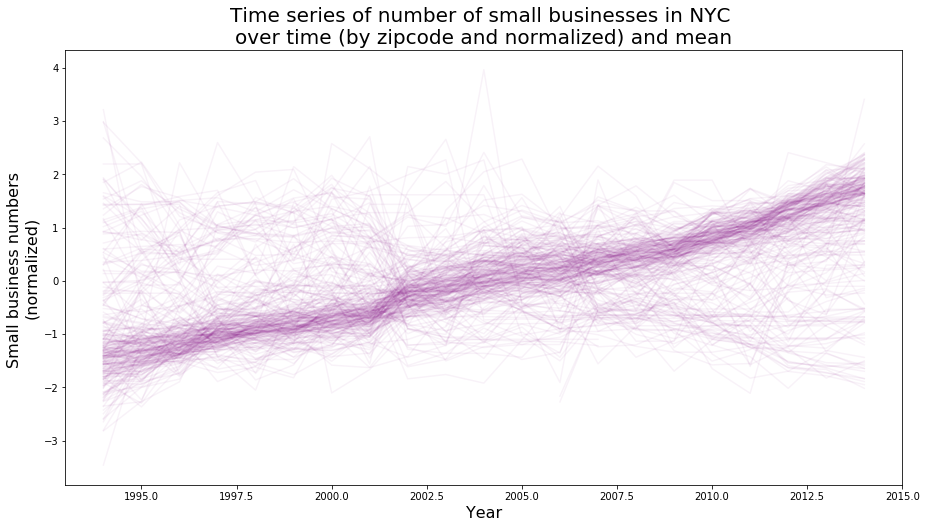

In [17]:

fig = plt.figure(figsize = (15,8))
plt.plot(Xn.T, alpha = 0.05,c = 'purple')


plt.xlabel('Year', fontsize = 16)
plt.ylabel('Small business numbers \n(normalized)', fontsize = 16)
plt.title('Time series of number of small businesses in NYC \nover time (by zipcode and normalized) and mean', 
          fontsize = 20);

**Figure 1:** Time series of number of establishments (normalised) by zipcode over time. There is a cluste of time series with increasing trend between 1994 and 2014. There are also some zip codes which decrease over this time, and they would form their own cluster, or separate clusters. 

There may also be some clusters which increase and then decrease over this time (again, they would form separate clusters to the increasing trend).

In [18]:
XnClean = Xn.dropna()


In [19]:
XnClean.head()

year,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
zip,,,,,,,,,,,,,,,,,,,,,
10001,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,-1.222326,...,0.432324,1.179819,2.152288,1.593481,0.381523,-0.082940,-0.184541,-0.126483,0.149292,0.845986
10002,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,-0.174982,...,0.522100,0.532058,0.529569,0.544506,0.753631,0.995120,1.094703,1.199265,1.283911,1.244077
10003,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,-0.391918,...,0.127855,0.261785,0.708216,0.778369,0.867655,0.912298,1.058983,1.234367,1.435260,1.613833
10004,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,-0.313478,0.108300,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945
10005,-2.819347,-2.263972,-0.463213,-0.278088,0.445582,-0.025645,0.731684,0.092162,0.008014,-0.732485,...,-0.496872,0.260457,0.496070,0.799002,0.512900,0.378264,0.967297,0.496070,0.883150,1.303888


# Clustering approach 1: K-means 

Use elbow method to determine umber of clusters to use.

In [20]:

def elbow(data,K):
#data is your input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid since we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    
    # elbow curve
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters', fontsize = 16)
    plt.ylabel('Average within-cluster sum of squares', fontsize = 16)
    plt.title('Elbow for KMeans clustering', fontsize = 20)
    plt.show()
    
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters', fontsize = 16)
    plt.ylabel('Percentage of variance explained', fontsize = 16)
    plt.title('Elbow for KMeans clustering', fontsize = 20)
    plt.show()

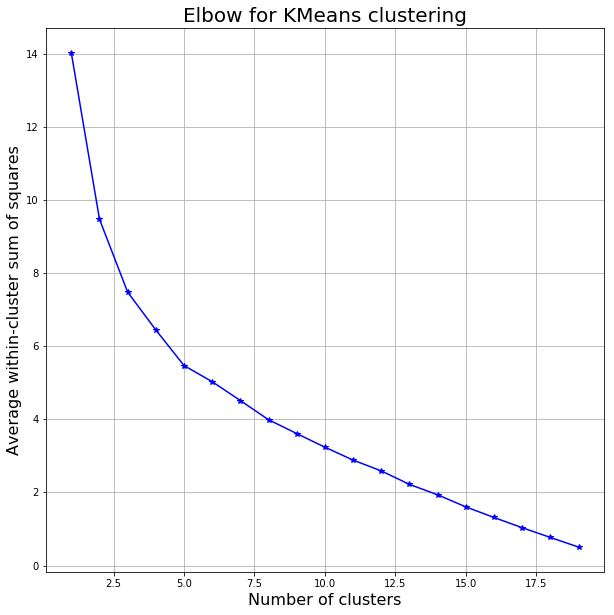

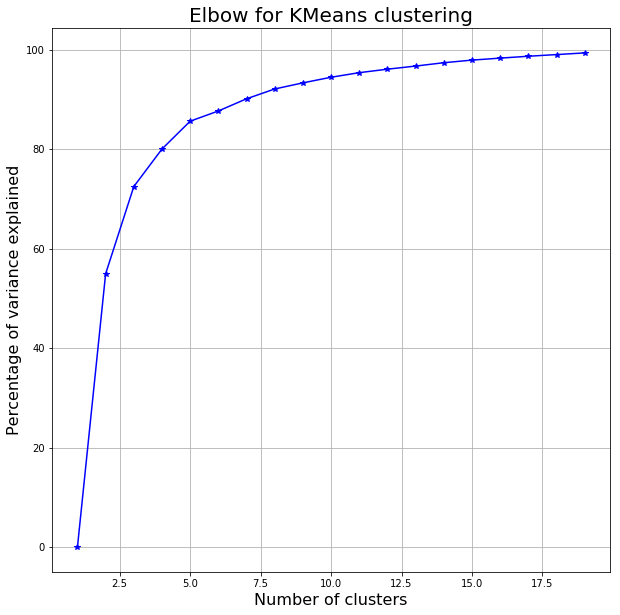

In [21]:
elbow(XnClean.T,range(1,20))

**Figures 2 and 3:** Plots of *number of clusters* with *Average within-cluster sum of squares* (top) and *Percentage of variance explained* (bottom). This helps to assess the appropriate number of cluster, for example if there were a kink in the line graph, or we were to observed some non-monotonic patterns.

Based on this output, we choose **5 clusters** which explains over 80% of the variance. 

In [22]:
clustering = KMeans(n_clusters = 5, random_state = 999)
gettinglearned = clustering.fit(XnClean)
clusterNumbers = gettinglearned.labels_
XnClean['clusterNumbers'] = clusterNumbers

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [23]:
gettinglearned.cluster_centers_.shape

(5, 21)

In [24]:
XnClean.shape

(230, 22)

In [25]:
# Set colors for plotting of clusters

colArray = ['lightblue', 'r', 'g', 'magenta', 'orange', "IndianRed"]

In [26]:
unique(clusterNumbers)

array([0, 1, 2, 3, 4], dtype=int32)

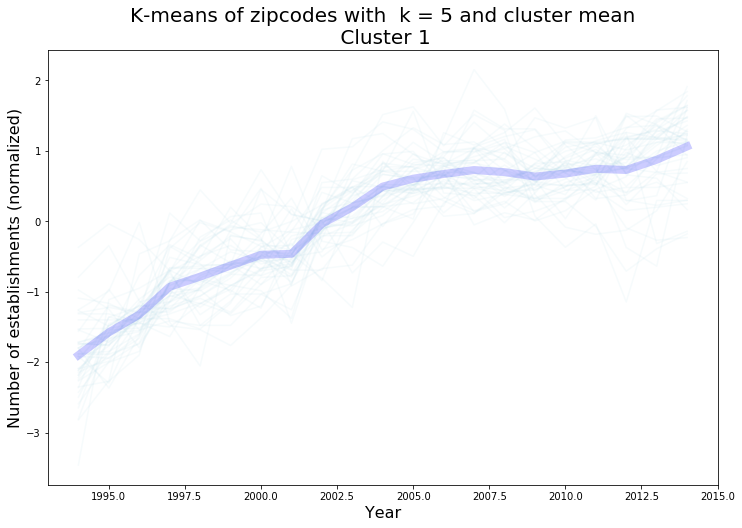

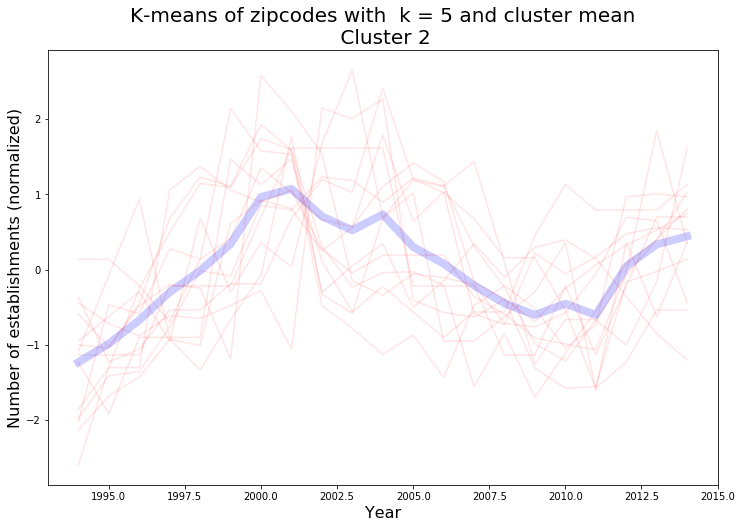

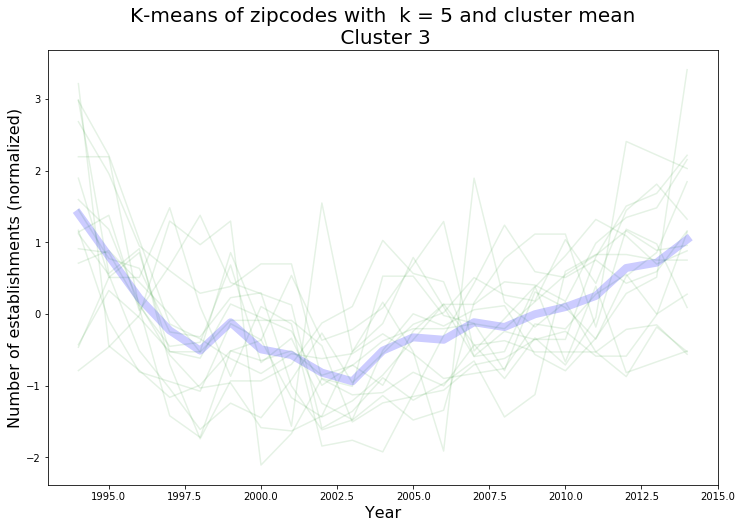

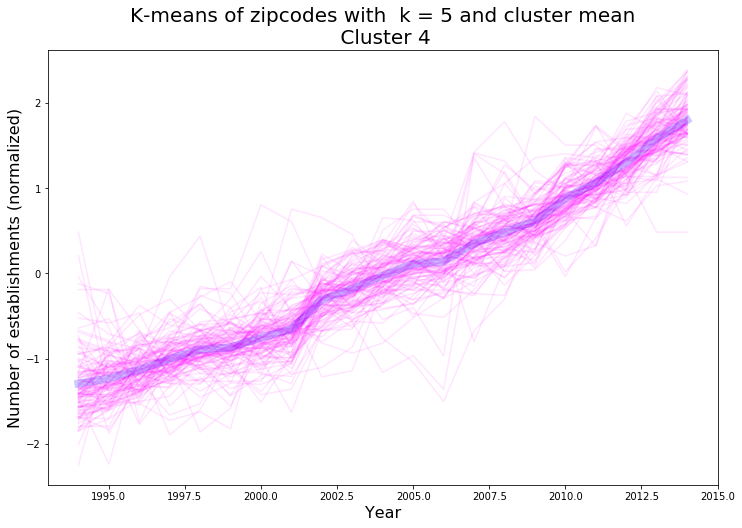

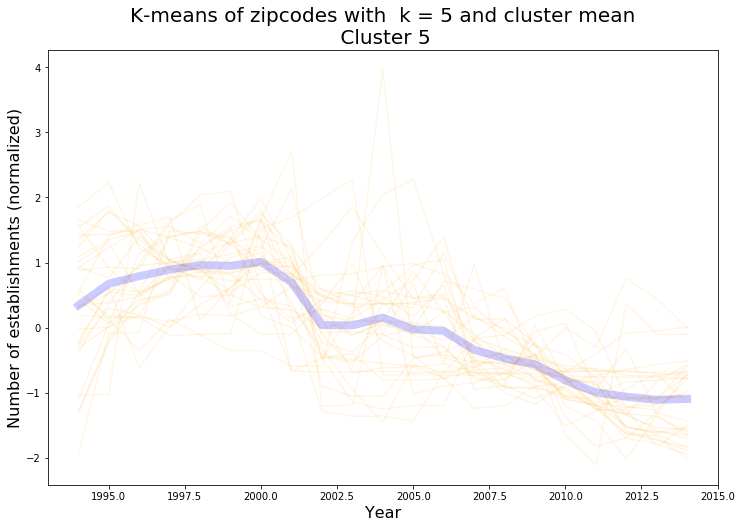

In [27]:
#loop to plot clusters and the cluster centroids (time series)

for i in unique(clusterNumbers):    
    fig, ax = plt.subplots(figsize = (12, 8))
    ax.plot(XnClean.drop(['clusterNumbers'],axis=1)[XnClean.clusterNumbers == i].T, alpha = 0.1, c = colArray[i]) 
    ax.plot(list(XnClean.drop(['clusterNumbers'],axis=1).columns), gettinglearned.cluster_centers_[i],
                  alpha = 0.2, lw = 8, c = 'b')
    pl.xlabel('Year', fontsize = 16)
    pl.ylabel('Number of establishments (normalized)', fontsize = 16)

    pl.title("K-means of zipcodes with  k = 5 and cluster mean\n Cluster %d"%(i+1), fontsize = 20);

**Figures 4 through 8:**  Using the K-means approach (and elbow method), five (5) clusters would appropriately describe the groups of time series. Clusters 1 and 2 show ~monotically increasing trends across the centroid of the clusters. Cluster 1 exhibits a more gradual increase, whereas Cluster 2 a steeper / rapid increase.

Cluster 5 also increases overall, although there is a local maximum and local minimum in years 2001 and 2009 respectively.

Cluster 4 is U-shaped with a dip and decrease until 2003, followed by increase until 2014.

Cluster 3 shows an initial slight increase until year 2000, followed by steady decrease through to 2014.

In terms of in-cluster variation, Clusters 1 and 2 are the most densely populated and closely fitted to their centroids when compared with the other decreasing or U-shaped clusters.

# Plot maps of clusters

In [28]:
dfMap =  XnClean.reset_index().merge(ZipShapedf,on='zip')
dfMap = gpd.GeoDataFrame(dfMap)
dfMap.head()

year,zip,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2007,2008,2009,2010,2011,2012,2013,2014,clusterNumbers,geometry
0,10001,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,...,2.152288,1.593481,0.381523,-0.082940,-0.184541,-0.126483,0.149292,0.845986,0,"POLYGON ((981958.6472873986 213464.4530421346,..."
1,10002,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,...,0.529569,0.544506,0.753631,0.995120,1.094703,1.199265,1.283911,1.244077,0,"POLYGON ((991339.8703228086 207576.7837151289,..."
2,10003,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,...,0.708216,0.778369,0.867655,0.912298,1.058983,1.234367,1.435260,1.613833,3,"POLYGON ((989830.469142139 207048.1263078749, ..."
3,10004,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,...,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945,3,"POLYGON ((981197.408652395 196571.0816452205, ..."
4,10004,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,...,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945,3,"POLYGON ((972696.8446168154 193014.5477478057,..."


In [29]:
def colorbar_index(ncolors, cmap, labels=None, **kwargs):
    """
    This is a convenience function to stop you making off-by-one errors
    Takes a standard colour ramp, and discretizes it,
    then draws a colour bar with correctly aligned labels
    """
    cmap = cmap_discretize(cmap, ncolors)
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(range(ncolors))
    if labels:
        colorbar.set_ticklabels(labels)
    return colorbar

def cmap_discretize(cmap, N):
    """
    Return a discrete colormap from the continuous colormap cmap.

        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.

    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)

    """
    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0., 0., 0., 0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N + 1)
    cdict = {}
    for ki, key in enumerate(('red', 'green', 'blue')):
        cdict[key] = [(indices[i], colors_rgba[i - 1, ki], colors_rgba[i, ki]) for i in xrange(N + 1)]
    return matplotlib.colors.LinearSegmentedColormap(cmap.name + "_%d" % N, cdict, 1024)


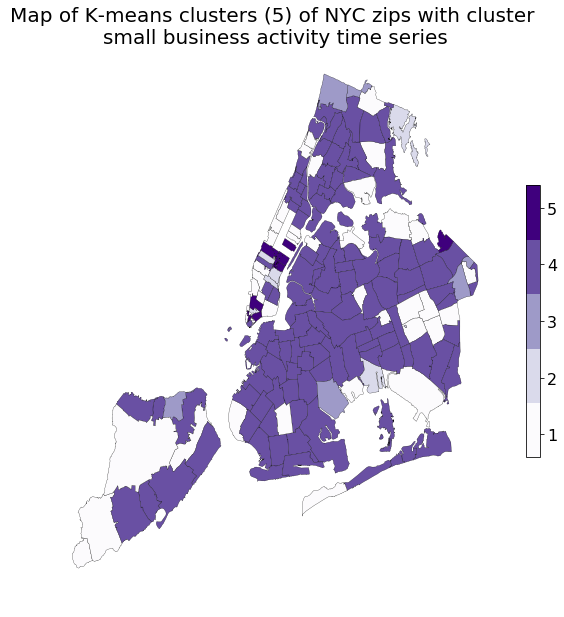

In [30]:
#Map of New York City zips plotted with colouring by cluster
###############################################################################
cp.choroplethNYC(dfMap, column = "clusterNumbers",  
                 edgecolor = 'black',cmap=plt.cm.Purples,  cb = False, lw=.25);

pl.title("Map of K-means clusters (5) of NYC zips with cluster \nsmall business "\
         "activity time series", fontsize = 20);

# Add a colour bar
cb = colorbar_index(ncolors=5, labels = [1, 2, 3, 4, 5], cmap=plt.cm.Purples, shrink=0.5)
cb.ax.tick_params(labelsize=16)

**Figure 9:** New York city zip codes plotted and grouped by cluster (k-means = 5). The largest cluster is number 4. Each time series within the cluster with strong positive increase number of establishments over time for the centroid cluster.

Cluster 1 is the second most popular and again exhibits an increasing trend.

The other clusters don't necessarily show a strong spatial connection, and exhibit more random patterns not increasing, or U-shaped.

In [31]:
ZipShapedf.head(), 

(     zip                                           geometry
 0  11436  POLYGON ((1038098.251871482 188138.3800067157,...
 1  11213  POLYGON ((1001613.712964058 186926.4395172149,...
 2  11212  POLYGON ((1011174.275535807 183696.33770971, 1...
 3  11225  POLYGON ((995908.3654508889 183617.6128015518,...
 4  11218  POLYGON ((991997.1134308875 176307.4958601296,...,)

In [32]:
XnClean.head()

year,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,clusterNumbers
zip,,,,,,,,,,,,,,,,,,,,,
10001,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,-1.222326,...,1.179819,2.152288,1.593481,0.381523,-0.082940,-0.184541,-0.126483,0.149292,0.845986,0
10002,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,-0.174982,...,0.532058,0.529569,0.544506,0.753631,0.995120,1.094703,1.199265,1.283911,1.244077,0
10003,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,-0.391918,...,0.261785,0.708216,0.778369,0.867655,0.912298,1.058983,1.234367,1.435260,1.613833,3
10004,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,0.108300,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945,3
10005,-2.819347,-2.263972,-0.463213,-0.278088,0.445582,-0.025645,0.731684,0.092162,0.008014,-0.732485,...,0.260457,0.496070,0.799002,0.512900,0.378264,0.967297,0.496070,0.883150,1.303888,0


In [33]:
#Drop previous cluster allocation

XnClean.drop(['clusterNumbers'], axis=1, inplace=True)

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


# Clustering approach 2: 
# Use some mad DBSCAN approach (the density-based algorithm for discovering clusters)

In [34]:
# Apply DBSCAN algorithm for clustering

db = DBSCAN(eps = 0.6, min_samples = 2).fit(XnClean)
labels = (db.labels_).astype(int)
num_clusters = len(set(labels)) - (1 if -1 in labels else 0) # the last statements removes outliers
clusters = pd.Series([XnClean.index[labels == i] for i in range(num_clusters)])
print('Number of clusters: %d' % num_clusters)


Number of clusters: 3


In [35]:
# Create centroids of clusters
centroids = db.components_

In [36]:
# Output of zips in each of the clusters

clusters

0    Int64Index([10009, 10026, 10029, 10031, 10035,...
1    Int64Index([11201, 11206, 11213, 11225], dtype...
2    Int64Index([11205, 11233, 11238], dtype='int64...
dtype: object

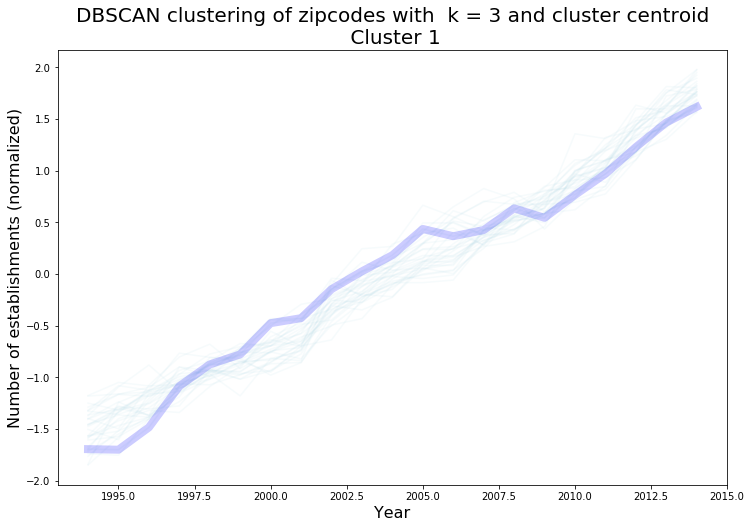

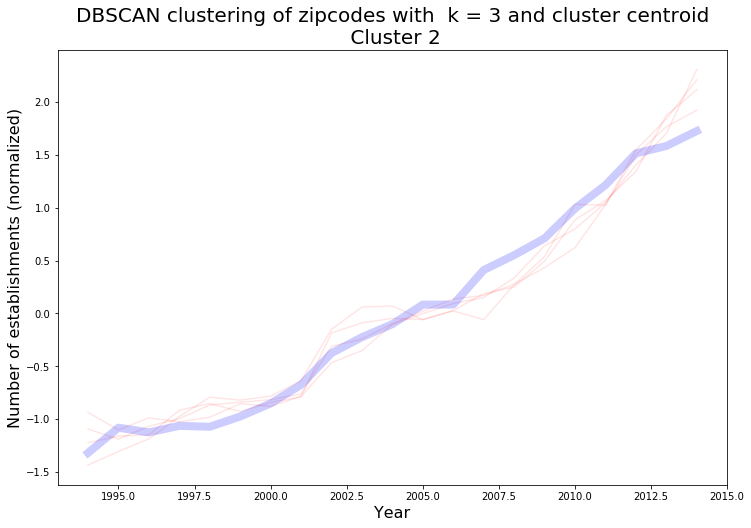

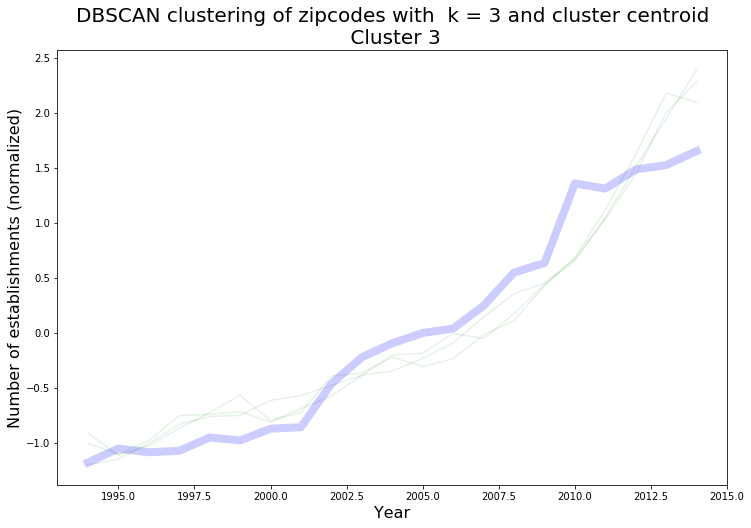

In [37]:
for i in range(0, num_clusters):    
    
    fig, ax = plt.subplots(figsize = (12, 8))
    ax.plot(XnClean.loc[clusters[i]].T, alpha = 0.1, c = colArray[i]) 
    ax.plot(list(XnClean.columns), centroids[i],
                  alpha = 0.2, lw = 8, c = 'b')
    
    #XnClean.loc[clusters[i]].mean().plot(alpha = 0.3, c = 'darkblue', lw = 8, label = 'Mean')
    plt.xlabel('Year', fontsize = 16)
    plt.ylabel('Number of establishments (normalized)', fontsize = 16)
    pl.title("DBSCAN clustering of zipcodes with  k = 3 and cluster centroid\n Cluster %d"%(i+1), fontsize = 20);

**Figures 10 through 12:**  Using the DBSCAN algorithm, three (3) are assigned. They all look quite similar, ~monotonically increasing.

Cluster 1 is the most popular with a fairly consistent growth rate. It best resembles a line out of the three.

Cluster 2 has a more accelerated growth rate, and there appears to be a hump in the series between years 2001 and 2006.

Cluster 3 has the most accelerated growth rate and fairly consistent trajectory across it's three composite series.

Overall the clustering technique is not great, because it classified a lot of the series as outliers (which has an underlying parametric assumption). It would be preferable to categorize more of the series.


In [38]:
XnClean['clusterNumbers'] = 0.0001

    

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [39]:
for i, lst in enumerate(clusters):
    XnClean['clusterNumbers'].loc[clusters[i]] = i + 1
   



/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [40]:
XnClean['clusterNumbers'].replace(0.0001, 0);

In [41]:
dfMap2 =  XnClean.reset_index().merge(ZipShapedf,on='zip')
dfMap2 = gpd.GeoDataFrame(dfMap2)
dfMap2.head()

year,zip,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2007,2008,2009,2010,2011,2012,2013,2014,clusterNumbers,geometry
0,10001,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,...,2.152288,1.593481,0.381523,-0.082940,-0.184541,-0.126483,0.149292,0.845986,0.0001,"POLYGON ((981958.6472873986 213464.4530421346,..."
1,10002,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,...,0.529569,0.544506,0.753631,0.995120,1.094703,1.199265,1.283911,1.244077,0.0001,"POLYGON ((991339.8703228086 207576.7837151289,..."
2,10003,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,...,0.708216,0.778369,0.867655,0.912298,1.058983,1.234367,1.435260,1.613833,0.0001,"POLYGON ((989830.469142139 207048.1263078749, ..."
3,10004,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,...,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945,0.0001,"POLYGON ((981197.408652395 196571.0816452205, ..."
4,10004,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,...,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945,0.0001,"POLYGON ((972696.8446168154 193014.5477478057,..."


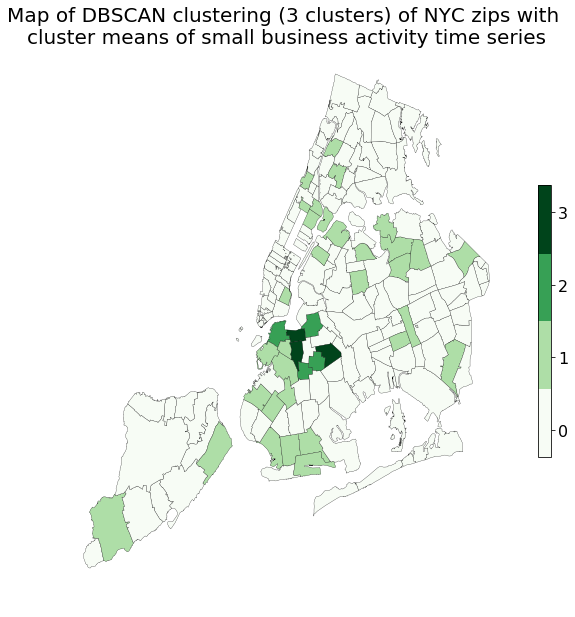

In [42]:
#Map of New York City zips plotted with colouring by cluster
###############################################################################
cp.choroplethNYC(dfMap2, column = "clusterNumbers",  edgecolor = 'black', 
                 cmap = plt.cm.Greens,  cb = False, lw=.25);

pl.title("Map of DBSCAN clustering (3 clusters) of NYC zips with "\
         "\ncluster means of small business activity time series", 
         fontsize = 20);

# Add a colour bar
cb = colorbar_index(ncolors = 4, labels = [0, 1, 2, 3], 
                    cmap = plt.cm.Greens, shrink = 0.5)
cb.ax.tick_params(labelsize = 16)

**Figures 13:**  The resulting clusters (k = 3) from the DBSCAN fit is plotted above. Cluster 1 is the largest cluster and shows strong prevalence of constantly increasing small business activity time series.

Cluster 0 represents the zip codes identified as outliers, shown in the dark green. There are lots of these (msot of the zip codes).

# Classification approach 3: 
# Use hierarchical agglomerative clustering (dendogram)

In [43]:
XnClean.index

Int64Index([10001, 10002, 10003, 10004, 10005, 10006, 10007, 10009, 10010,
            10011,
            ...
            11433, 11434, 11435, 11436, 11451, 11691, 11692, 11693, 11694,
            11697],
           dtype='int64', name=u'zip', length=230)

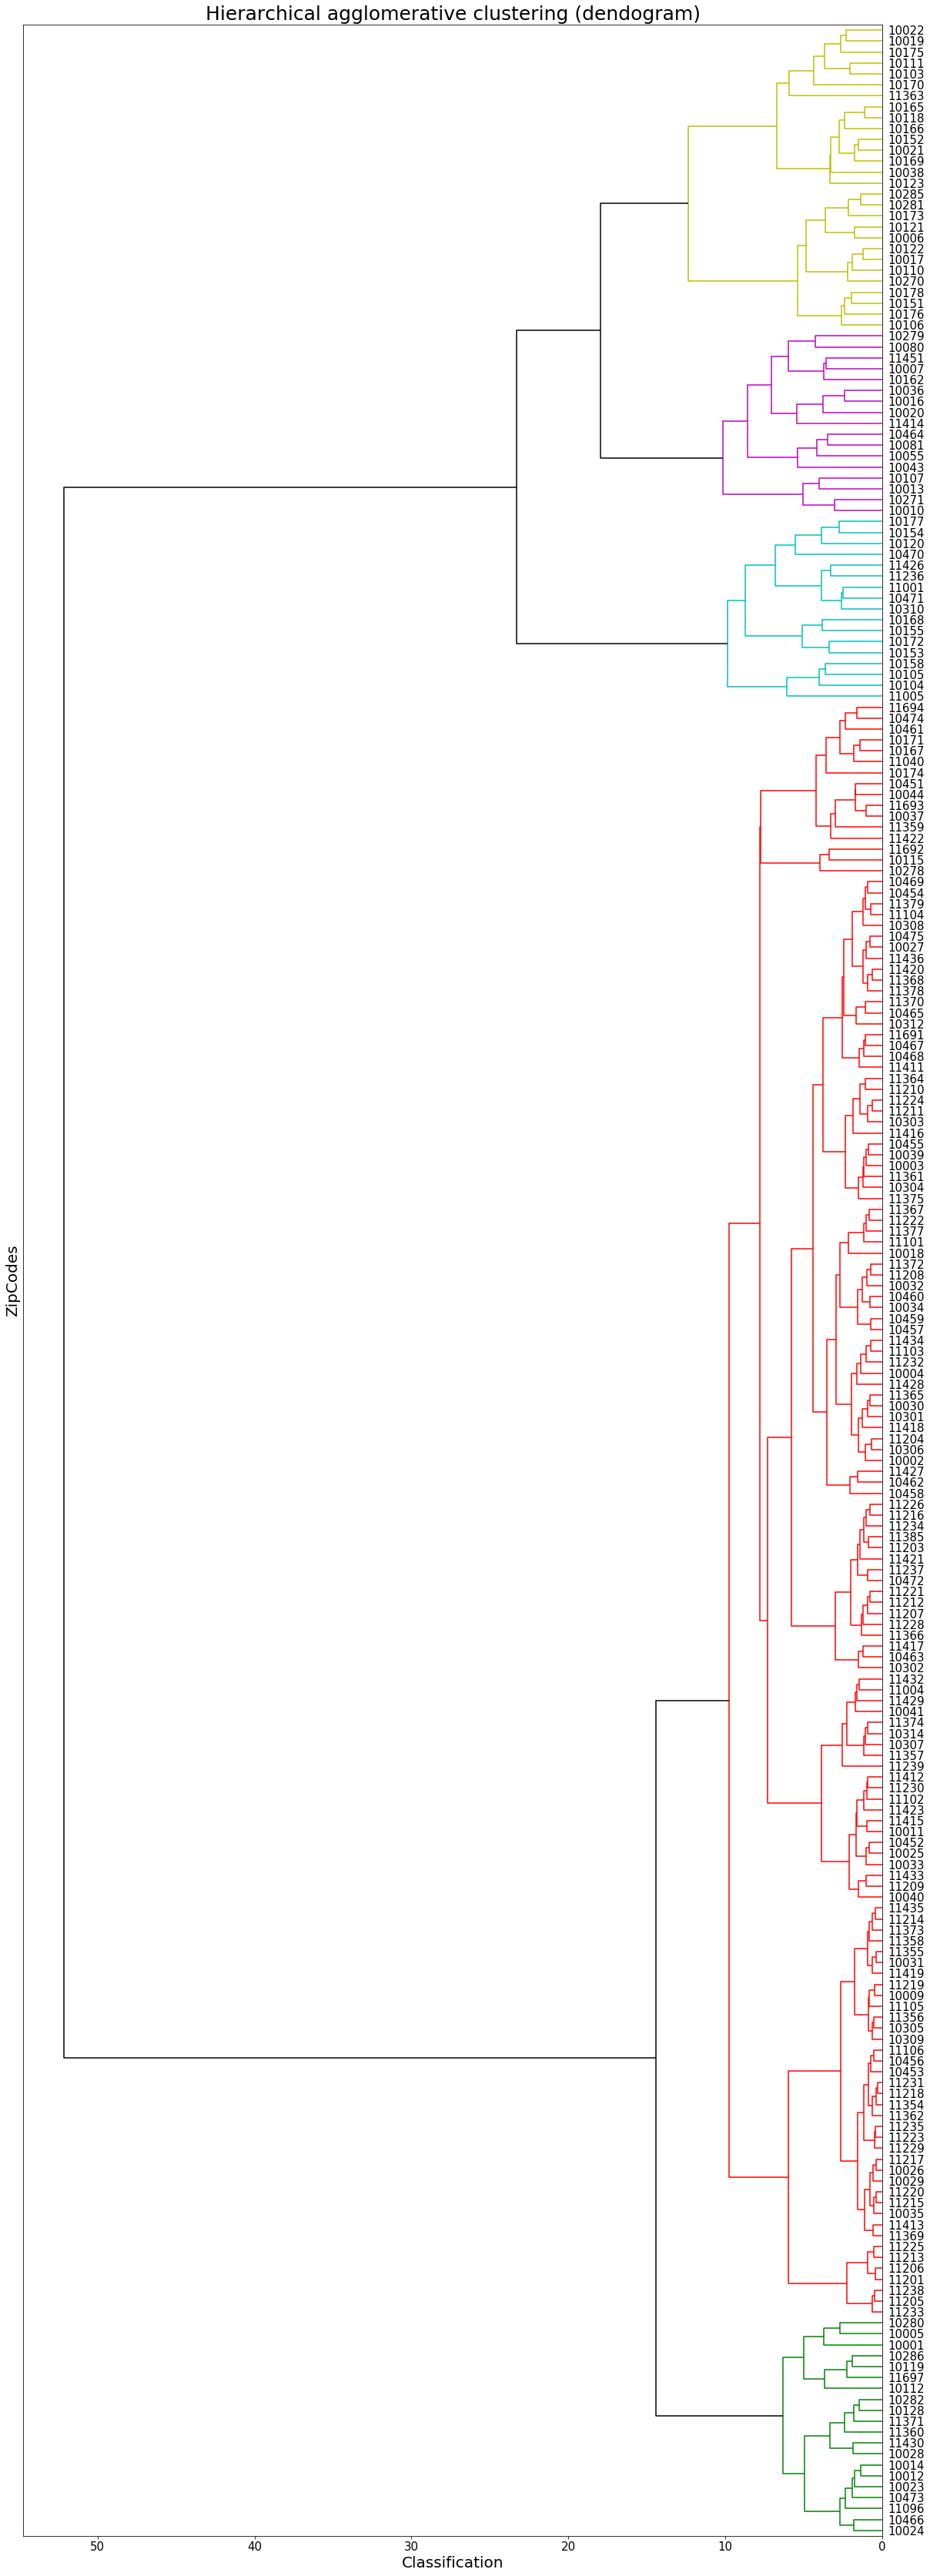

In [44]:
# Create hierarchical agglomerative classification
###############################################################################
fig = pl.figure(figsize=(20,60))

ddg = scp.hierarchy.dendrogram(scp.hierarchy.linkage(XnClean, 
                                                     method='ward'),
                               labels = XnClean.index,
                               leaf_rotation=270.,leaf_font_size=20, 
                               truncate_mode='lastp', p=250, 
                               show_contracted=True, color_threshold = 14, 
                               orientation='left', above_threshold_color='k'
                              )  # font size for the x axis labels)
#pl.xticks(rotation=90)
pl.title("Hierarchical agglomerative clustering (dendogram)", 
         fontsize = 25);
pl.xlabel("Classification", fontsize=20)
pl.ylabel("ZipCodes", fontsize=20)
pl.yticks(fontsize=15, rotation=0)
pl.xticks(fontsize=15)
pl.grid('off')

**Figures 14:** The final clustering (classification) method used is compilation of a dendogram, or Hierarchical agglomerative clustering. The approach developed five (5) clusters.

#### Classify zipcodes using dendogram

In [45]:

# Create empty arrays
clustersagc = []

# Run 5 clusters

agc = AgglomerativeClustering(n_clusters = 5,  
                            compute_full_tree=True).fit(XnClean)
clustersagc.append(agc.labels_)


In [46]:
XnClean['clusterNumbers'] = clustersagc[0]

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [47]:
dfMap3 =  XnClean.reset_index().merge(ZipShapedf,on='zip')
dfMap3 = gpd.GeoDataFrame(dfMap3)
dfMap3.head()

year,zip,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2007,2008,2009,2010,2011,2012,2013,2014,clusterNumbers,geometry
0,10001,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,...,2.152288,1.593481,0.381523,-0.082940,-0.184541,-0.126483,0.149292,0.845986,4,"POLYGON ((981958.6472873986 213464.4530421346,..."
1,10002,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,...,0.529569,0.544506,0.753631,0.995120,1.094703,1.199265,1.283911,1.244077,3,"POLYGON ((991339.8703228086 207576.7837151289,..."
2,10003,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,...,0.708216,0.778369,0.867655,0.912298,1.058983,1.234367,1.435260,1.613833,3,"POLYGON ((989830.469142139 207048.1263078749, ..."
3,10004,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,...,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945,3,"POLYGON ((981197.408652395 196571.0816452205, ..."
4,10004,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,...,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945,3,"POLYGON ((972696.8446168154 193014.5477478057,..."


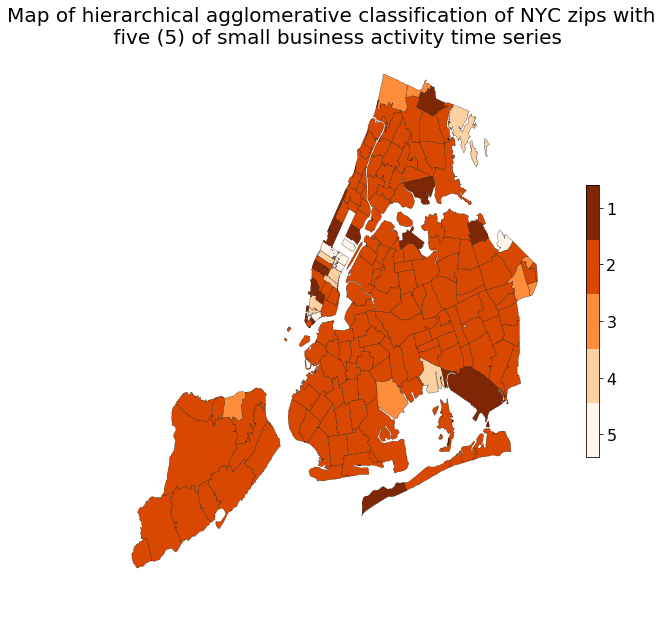

In [48]:
#Map of New York City zips plotted with colouring by cluster
###############################################################################
cp.choroplethNYC(dfMap3, column = "clusterNumbers",  edgecolor = 'black', 
                 cmap = plt.cm.Oranges,  cb = False, lw=.25);

pl.title("Map of hierarchical agglomerative classification of NYC zips with "\
         "\n five (5) of small business activity time series", 
         fontsize = 20);

# Add a colour bar
cb = colorbar_index(ncolors = 5, labels = [5, 4, 3, 2, 1], 
                    cmap = plt.cm.Oranges, shrink = 0.5)
cb.ax.tick_params(labelsize = 16)

**Figures 15:** Plot of NYC clusters using hierarchical agglomerative classification and k = 5 clusters. The result is comparable to the k-means clustering with five (5) clusters also.

Staten Island's classification has changed significantly also compared with the k-means, and cluster 4 is the most prevalent one here. 

There aren't strong spatial patterns, aside from cluster 4 being the most prevalent cluster.

## THANK YOU!